In [8]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

from metavision_core.event_io import EventsIterator
import numpy as np
import matplotlib.pyplot as plt

from lib.utils import *
from lib.plot_utils import *   
from lib.event_processing import *

# Get the runtimes of the different methods
import time

In [4]:
path = "../data/recordings/recording_2024-01-19_15-45-11.raw"
mv_iterator = EventsIterator(input_path=path, delta_t=1000000)

frames = []
for evs in mv_iterator:
    # Create an array that transforms the events into an image
    height, width = mv_iterator.get_size()  # Camera Geometry, WHY DOES THIS NOT WORK?

    # Get the indices from ev and create an array with the pixel values
    img = events_colapsing(evs, width, height)
            
    frames.append(img)

In [5]:
print(len(frames))

11


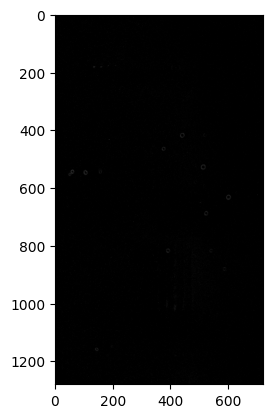

In [6]:
plot_image(frames[1])

In [ ]:
# RUNTIME COMPARATION  

import cv2

def treshold_filter_2(img, treshold):
    '''
    Deletes the pixels with a value below the treshold.

    Parameters
    ----------
    img : numpy array
        Image to be filtered.
    treshold : int
        Treshold value.

    Returns
    -------
    filtered_img : numpy array
        Filtered image.
    '''
    
    # Create a copy of the input image
    filtered_img = np.copy(img)

    # Filter the image with a threshold
    filtered_img[filtered_img < treshold] = 0

    return filtered_img

max_pixel_value = np.max(frames[11])
treshold = round(max_pixel_value*0.7) # 50% of the max pixel value, MODIFY
print(treshold)



# Treshold filter
start = time.time()
filtered_frames_1 = []
for frame in frames:
    filtered_frames_1.append(treshold_filter_2(frame, treshold))
end = time.time()
treshold2_time = end - start

# Treshold filter
start = time.time()
filtered_frames_2 = []
for frame in frames:
    filtered_frames_2.append(treshold_filter(frame, treshold))
end = time.time()
treshold_time = end - start

frames = frames/np.max(frames) # Normalize the frames

start = time.time()
filtered_frames_3 = []
for frame in frames:
    filtered_frames_3.append(cv2.threshold(frame, treshold, 1, cv2.THRESH_TOZERO)[1])
end = time.time()
treshold_time_cv = end - start

# Open cv

print(f'Treshold filter time: {treshold_time}', f'Treshold filter time 2: {treshold2_time}',
      f'Treshold filter time cv: {treshold_time_cv}')
# plot_image(filtered_frames_1[11])
plot_image(filtered_frames_3[11])
print(np.max(filtered_frames_1[11]-filtered_frames_3[11]))

## Max value cluster 

In [45]:
max_index = np.array([5,5])
filtered_img = np.zeros([10,10])
pixel_range = 3



mask = np.zeros_like(filtered_img, dtype=bool)

mask[max_index[0] - pixel_range:max_index[0] + pixel_range + 1,
             max_index[1] - pixel_range:max_index[1] + pixel_range + 1] = True

print(mask)

[[False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False False False False False False False False False]]


In [26]:
pixel_range:max_index[1]

runtime:  1.0343871116638184
[[array([437, 188]), 320, array([434, 187])], [array([624, 701]), 224, array([625, 701])], [array([718, 272]), 396, array([718, 271])], [array([261, 225]), 414, array([260, 224])], [array([943, 242]), 328, array([944, 241])], [array([547, 106]), 2028, array([543, 108])], [array([547,  58]), 2407, array([540,  62])], [array([813, 271]), 355, array([814, 273])], [array([893, 493]), 1205, array([894, 495])], [array([530, 513]), 2330, array([534, 518])], [array([175,  72]), 227, array([173,  73])], [array([633, 599]), 2136, array([628, 596])], [array([815, 391]), 1442, array([812, 389])], [array([420, 439]), 2040, array([421, 435])], [array([948, 295]), 208, array([948, 295])], [array([1261,  352]), 383, array([1266,  354])], [array([146, 120]), 326, array([144, 121])], [array([688, 522]), 1496, array([684, 520])], [array([1094,  212]), 267, array([1094,  214])], [array([1266,  112]), 181, array([1272,  111])]]


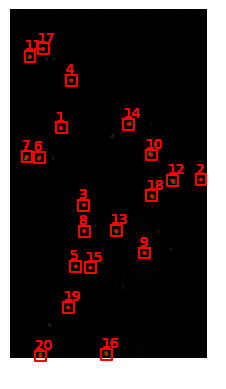

runtime:  1.6257660388946533
[[array([435, 188]), 295, array([434, 187])], [array([623, 701]), 222, array([625, 701])], [array([717, 271]), 366, array([718, 271])], [array([261, 225]), 403, array([260, 224])], [array([943, 242]), 314, array([944, 241])], [array([547, 106]), 2026, array([543, 108])], [array([547,  58]), 2376, array([540,  62])], [array([812, 271]), 328, array([814, 273])], [array([893, 493]), 1147, array([894, 495])], [array([529, 513]), 2314, array([534, 518])], [array([174,  71]), 211, array([173,  73])], [array([633, 599]), 2132, array([628, 596])], [array([815, 391]), 1425, array([812, 389])], [array([420, 439]), 2015, array([421, 435])], [array([948, 294]), 197, array([948, 295])], [array([1261,  352]), 377, array([1266,  354])], [array([145, 120]), 307, array([144, 121])], [array([688, 522]), 1486, array([684, 520])], [array([1094,  212]), 251, array([1094,  214])], [array([1266,  111]), 175, array([1272,  111])]]


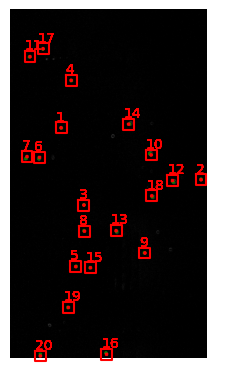

In [53]:
def max_value_cluster(img, pixel_range, n_clusters, iterations=1):

    '''
    Creates a list of clusters searching the the maximun pixel value and performing the center of mass 
    of the pixels around it. The pixels that are part of the cluster are deleted and the process is repeated.

    Parameters
    ----------
    img : numpy array
        Image to be filtered.
    pixel_range : int
        Range of pixels to be considered around the maximun pixel value to perform the center of mass 
        (clustering).
    n_clusters : int
        Number of clusters to be found.
    iterations : int, optional
        Number of times the clustering is performed. When iterating the clusters are ordered by the cluster 
        mass and the index used a preliminary stimations . The default is 1.

    Returns
    -------
    clusters : list
        List of clusters. Each cluster is a list with the following structure:
            [ [x_pixel, y_pixel], cluster comulative mass, inital cluster position [x_max, y_max] ]    
    
    '''
    # Create a copy of the input image
    filtered_img = np.copy(img)

    clusters = []

    for i in range(n_clusters):
        # Get the maximun pixel value
        max_index = np.unravel_index(np.argmax(filtered_img), filtered_img.shape)

        cluster_x = 0
        cluster_y = 0
        cluster_mass = 0
        # Performs the clustering on the pixel range around the maximun pixel value
        for i in range(-pixel_range, pixel_range):
            for j in range(-pixel_range, pixel_range):
                if max_index[0]+i < filtered_img.shape[0] and max_index[1]+j < filtered_img.shape[1]:
                    
                    cluster_x += filtered_img[max_index[0] + i , max_index[1] + j ] * i
                    cluster_y += filtered_img[max_index[0] + i , max_index[1] + j ] * j
                    cluster_mass += filtered_img[max_index[0] + i , max_index[1] + j ] 

                    # Delete the pixels that are part of the cluster to find another maximun
                    filtered_img[max_index[0] + i , max_index[1] + j ] = 0

        if cluster_mass != 0:
            clusters.append([ np.round(max_index + [cluster_x, cluster_y]/cluster_mass).astype(int), 
                            cluster_mass, 
                            np.array(max_index)]) 

    return clusters

def max_value_cluster_2(img, pixel_range, n_clusters):
    # Create a copy of the input image
    filtered_img = np.copy(img)

    clusters = []

    for i in range(n_clusters):
        # Get the maximun pixel value
        max_index = np.unravel_index(np.argmax(filtered_img), filtered_img.shape)

        cluster_x = 0
        cluster_y = 0
        cluster_mass = 0

        # Create a mask to select the pixels within the pixel range
        mask = np.zeros_like(filtered_img, dtype=bool)
        mask[max_index[0] - pixel_range:max_index[0] + pixel_range + 1,
             max_index[1] - pixel_range:max_index[1] + pixel_range + 1] = True


        # Get the coordinates and values of the pixels within the mask
        coords = np.argwhere(mask)
        values = filtered_img[mask]

        # Perform the clustering using vectorized operations
        cluster_x = np.sum(coords[:, 0] * values)
        cluster_y = np.sum(coords[:, 1] * values)
        cluster_mass = np.sum(values)

        # Calculate the cluster centroid
        centroid = None 
        if cluster_mass != 0:
            centroid = np.round([cluster_x, cluster_y] / cluster_mass).astype(int)
        cluster_position = np.array(max_index)

        # Append the cluster to the list
        clusters.append([centroid , cluster_mass, cluster_position])

        # Set the pixels within the mask to zero
        filtered_img[mask] = 0

    return clusters

start = time.time()
filtered_frames_1 = []
for frame in frames:
    filtered_frames_1.append(max_value_cluster_2(frame, pixel_range = 20, n_clusters = 20))
end = time.time()
print('runtime: ', end - start )
print(filtered_frames_1[2])
plot_cluster(frames[2], filtered_frames_1[2], 20)

start = time.time()
filtered_frames_1 = []
for frame in frames:
    filtered_frames_1.append(max_value_cluster(frame, pixel_range = 20, n_clusters = 20, iterations=1))
end = time.time()
print('runtime: ', end - start )
print(filtered_frames_1[2])
plot_cluster(frames[2], filtered_frames_1[2], 20)



In [2]:
import numpy as np
np.log(3.14261724)

1.1450559686622388